In [1]:
%matplotlib qt

In [83]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import numpy as np
from glob import glob
from scipy import signal
from plotly import express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from plotly_resampler import (
    register_plotly_resampler,
    FigureWidgetResampler,
    FigureResampler,
)

# register_plotly_resampler(mode="widget")

In [84]:
!make -f stages/test/makefile
%time !./stages_test

g++ -MM -DTEST -I. tides2/ramp/ramp_extractor.cc -MF build/stages_test/ramp_extractor.d -MT build/stages_test/ramp_extractor.o
cat build/stages_test/stages_test.d build/stages_test/ramp_extractor.d build/stages_test/segment_generator.d build/stages_test/resources.d build/stages_test/units.d build/stages_test/random.d build/stages_test/quantizer.d build/stages_test/braids_quantizer.d > build/stages_test/depends.mk
g++ -c -DTEST -g -Wall -Werror -msse2 -Wno-unused-variable -O2 -I. stages/test/stages_test.cc -o build/stages_test/stages_test.o
g++ -c -DTEST -g -Wall -Werror -msse2 -Wno-unused-variable -O2 -I. tides2/ramp/ramp_extractor.cc -o build/stages_test/ramp_extractor.o
g++ -c -DTEST -g -Wall -Werror -msse2 -Wno-unused-variable -O2 -I. stages/segment_generator.cc -o build/stages_test/segment_generator.o
g++ -g -o stages_test build/stages_test/stages_test.o build/stages_test/ramp_extractor.o build/stages_test/segment_generator.o build/stages_test/resources.o build/stages_test/units.o 

In [85]:
new = {}
stock = {}
for fn in glob("stages_*wav"):
    try:
        n = wavfile.read(fn)[1]
    except Exception as e:
        print(fn)
        print(e)
        continue
    new[fn[:-4]] = n
    try:
        s = wavfile.read(f"stages_test_reference/{fn}")[1]
        stock[fn[:-4]] = s
    except:
        print(f"stock file not found for {fn}; skipping")
        continue
    if (s == n).all():
        print(f"✅ {fn}")
    else:
        print(f"❌ {fn}")
        for i, label in enumerate(["value", "segment", "phase"], 1):
            if (s.T[i] == n.T[i]).all():
                print(f"\t✅ {label}")
            else:
                ixs = np.where(s.T[i] != n.T[i])[0]
                print(f"\t❌ {label}")
                f = FigureWidgetResampler(
                    make_subplots(
                        rows=1,
                        cols=1,
                        specs=[[{"secondary_y": True}]],
                        shared_xaxes=True,
                    )
                )
                # f.add_trace(dict(y=s.T[0], name="gate"))
                # f.add_trace(dict(y=s.T[i], name="old"))
                # f.add_trace(dict(y=n.T[i], name="new"))
                xs = np.arange(len(s.T[i]))
                f.add_trace(dict(name="gate"), hf_y=s.T[0], hf_x=xs)
                f.add_trace(dict(name="old"), hf_y=s.T[i], hf_x=xs)
                f.add_trace(dict(name="new"), hf_y=n.T[i], hf_x=xs)
                f.add_trace(
                    dict(name="new - old"), hf_y=n.T[i] - s.T[i], secondary_y=True
                )
                f.update_layout(
                    title=f"{fn} - {label}",
                    xaxis_range=[ixs[0], ixs[-1]],
                )
                display(f)
                # f.update_xaxes(range=[ixs[0], ixs[-1]])
                # f.show()
                # plt.figure()
                # plt.plot(s.T[i], label="old")
                # plt.plot(n.T[i], label="new")
                # plt.title(f"{fn} - {label}")
                # plt.xlim(ixs[0], ixs[-1])
                # plt.legend()

✅ stages_timed_pulse.wav
✅ stages_tm_05.wav
✅ stages_single_decay.wav
✅ stages_random_spline_lfo.wav
✅ stages_free_running_lfo.wav
✅ stages_random_white_noise.wav
✅ stages_portamento.wav
✅ stages_tap_lfo_audio_rate.wav
✅ stages_tm_00.wav
✅ stages_tm_50.wav
✅ stages_tm_25.wav
✅ stages_two_step.wav
✅ stages_tm_50_quantized.wav
✅ stages_random_sine_lfo.wav
stages_free_running_lfo_fast.wav
cannot reshape array of size 6122 into shape (4)
✅ stages_random_tap_lfo.wav
✅ stages_tap_lfo.wav
✅ stages_random_brownian_lfo.wav
✅ stages_random_stepped_lfo.wav
✅ stages_delay.wav
✅ stages_sh.wav
✅ stages_gate.wav
✅ stages_adsr.wav
✅ stages_random_brown_noise.wav


In [12]:
rand_tap = new["stages_random_tap_lfo"].T
((np.diff(rand_tap[0]) > 0) == (np.diff(rand_tap[1]) != 0)).all()


True

In [3]:
px.line(y = new["stages_tap_lfo"].T[0])

FigureWidgetResampler({
    'data': [{'hovertemplate': 'x=%{x}<br>y=%{y}<extra></extra>',
              'legen…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
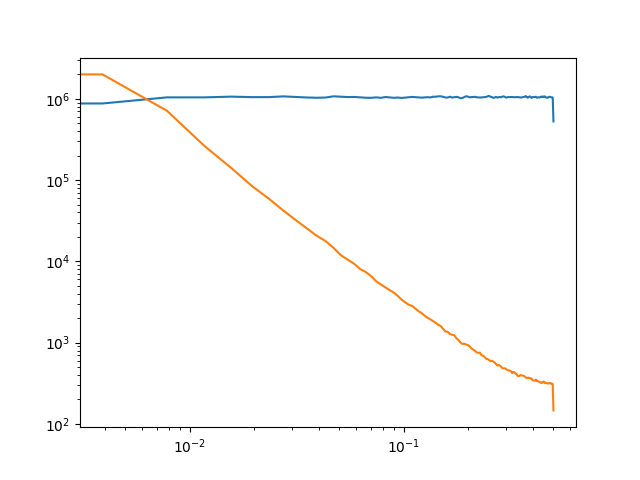

In [47]:
plt.figure()
plt.loglog(*signal.welch(new["stages_random_white_noise"].T[1], scaling="spectrum"))
plt.loglog(*signal.welch(new["stages_random_brown_noise"].T[1], scaling="spectrum"))

In [4]:
phase = new["stages_tap_lfo_audio_rate"].T[3]
gate = new["stages_tap_lfo_audio_rate"].T[0]

In [159]:
phase_peaks = signal.find_peaks(phase)[0]
gate_peaks = signal.find_peaks(gate)[0]


In [160]:
32000 / np.diff(phase_peaks).mean(), 32000 / np.diff(gate_peaks).mean()

(1031.194960297181, 1031.1950632948974)

In [5]:
plt.figure()
plt.plot(gate)
plt.plot(phase)


libGL error: MESA-LOADER: failed to open iris: /home/bryan/mambaforge/lib/python3.9/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /usr/lib64/dri/iris_dri.so) (search paths /usr/lib64/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open swrast: /home/bryan/mambaforge/lib/python3.9/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /usr/lib64/dri/swrast_dri.so) (search paths /usr/lib64/dri, suffix _dri)
libGL error: failed to load driver: swrast


In [11]:
x = np.arange(1_000_000)
noisy_sin = (3 + np.sin(x / 200) + np.random.randn(len(x)) / 10) * x / 1_000

# OPTION 1 - FigureWidgetResampler: dynamic aggregation via `FigureWidget.layout.on_change`
fig = FigureWidgetResampler(go.Figure())
fig.add_trace(dict(name="noisy sine", showlegend=True), hf_x=x, hf_y=noisy_sin)
fig.show()

/home/bryan/mambaforge/envs/py11/lib/python3.11/site-packages/plotly_resampler/figure_resampler/figure_resampler_interface.py:327: FutureWarning:

is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.

